# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


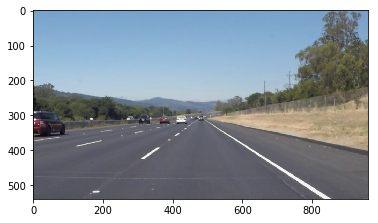

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [5]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg']

In [7]:
print(len(os.listdir("test_images/")))

6


In [8]:
myimages = os.listdir("test_images/")
print(myimages[3])

solidYellowLeft.jpg


In [9]:
directory = "test_image/"
path = directory + myimages[3]
print(path)
    

test_image/solidYellowLeft.jpg


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [10]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

# Importing a set of images
def importimages(directory):
    """
    This function imports all the images from a given directory
    """
    myimages = os.listdir(directory)
    imagelist = []

    for img in myimages:
        path = directory + img
        imagelist.append(path)
    
    return imagelist

# I first defined this method to be used as a test method for processing images in a directory
def hough_img_directory(directory):
    """
    This function processes a directory of images and outputs a number of images that
    show each step of image processing. This function expects color images. This function is meant
    to be used for test purposes
    
    Arguments:
        directory - a directory of color images
        
    Returns:
        my_image - the original image that was processed
        my_gray - the original image converted to gray scale
        my_blur_gray - image after Gaussian blurring
        my_edges - image after finding Canny edges
        my_masked_image - image after applying mask
        my_line_image - image after drawing Hough Lines
        my_result_image - a color image with the Hough Lines overlayed on top
    """

    # Define parameters
    kernel_size = 5
    low_threshold = 50
    high_threshold = 150

    rho = 2
    theta = np.pi/180
    threshold = 50
    min_line_length = 100
    max_line_gap = 60


    myimages = importimages(directory);
    # Empty arrays to hold output images
    my_image = []
    my_gray = []
    my_blur_gray = []
    my_edges =[]
    my_masked_image = []
    my_line_image = []
    my_result_image = []
    
    final_result = []

    for img in myimages:
        
        image = mpimg.imread(img)
        gray = grayscale(image)

        # Apply Gaussian smoothing and apply Canny
        blur_gray = gaussian_blur(gray, kernel_size)
        edges = canny(blur_gray, low_threshold, high_threshold)

        # Define region of interest
        # Defining vertices based on intuition of images
        width = image.shape[1]
        height = image.shape[0]
        # bottom of image minus noise past left lane marker
        bottom_left = (80,height)
        # center of lane FOV usually in center of image, we want top left mask to be to the left of it slightly
        top_left = (width/2-50, height/2+50)
        # bottom of image minus noise past right lane marker
        bottom_right = (width-80,height)
        # center of lane FOV usually in center of image, we want top right mask to be to the right of it slightly
        top_right = (width/2+50, height/2+50)

        vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
        masked_image = region_of_interest(edges, vertices)


        # Create Hough Lines
        line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)

        # Create weighted Image and store
        weighted_image = weighted_img(line_image, image, α=0.8, β=1., γ=0.)
        
        # Append all results
        my_image.append(image)
        my_gray.append(gray)
        my_blur_gray.append(blur_gray)
        my_edges.append(edges)
        my_masked_image.append(masked_image)
        my_line_image.append(line_image)
        my_result_image.append(weighted_image)
        
    
    return my_image, my_gray, my_blur_gray, my_edges, my_masked_image, my_line_image, my_result_image

def display_lane_results(directory):
    my_image, my_gray, my_blur_gray, my_edges, my_masked_image, my_line_image, my_result_image = hough_img_directory(directory)
    
    for i in range(len(my_image)):
        plt.figure(figsize=(25,15))
        plt.subplot(171), plt.imshow(my_image[i]) 
        plt.title("origin"), plt.xticks([]), plt.yticks([])
        plt.subplot(172), plt.imshow(my_gray[i],cmap='gray')
        plt.title("gray"), plt.xticks([]), plt.yticks([])
        plt.subplot(173), plt.imshow(my_blur_gray[i], cmap='gray')
        plt.title("blur"), plt.xticks([]), plt.yticks([])
        plt.subplot(174), plt.imshow(my_edges[i], cmap='gray')
        plt.title("edges"), plt.xticks([]), plt.yticks([])
        plt.subplot(175), plt.imshow(my_masked_image[i], cmap='gray')
        plt.title("roi"), plt.xticks([]), plt.yticks([])
        plt.subplot(176), plt.imshow(my_line_image[i], cmap='gray')
        plt.title("lines"), plt.xticks([]), plt.yticks([])
        plt.subplot(177), plt.imshow(my_result_image[i])
        plt.title("result"), plt.xticks([]), plt.yticks([])
        plt.show()
        
    return



In [11]:
def find_lane_lines(image):
    """
    This function takes a color image and overlays lane lines on it
    """
    
    # Define parameters
    kernel_size = 5
    low_threshold = 50
    high_threshold = 150

    rho = 2
    theta = np.pi/180
    threshold = 50
    min_line_length = 100
    max_line_gap = 60
    
    # Process image
    gray = grayscale(image)

    # Apply Gaussian smoothing and apply Canny
    blur_gray = gaussian_blur(gray, kernel_size)
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Define region of interest
    # Defining vertices based on intuition of images
    width = image.shape[1]
    height = image.shape[0]
    # bottom of image minus noise past left lane marker
    bottom_left = (80,height)
    # center of lane FOV usually in center of image, we want top left mask to be to the left of it slightly
    top_left = (width/2-50, height/2+50)
    # bottom of image minus noise pass right lane marker
    bottom_right = (width-80,height)
    # center of lane FOV usually in center of image, we want top right mask to be to the right of it slightly
    top_right = (width/2+50, height/2+50)

    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)


    # Create Hough Lines
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)

    # Create weighted Image and store
    weighted_image = weighted_img(line_image, image, α=0.8, β=1., γ=0.)
    
    return weighted_image

In [136]:
# Show results of image transformation and Hough Lines
my_image, my_gray, my_blur_gray, my_edges, my_masked_image, my_line_image, my_result_image = hough_img_directory("test_images/")

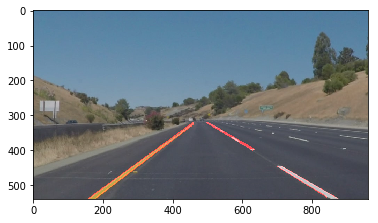

In [166]:
plt.imshow(my_result_image[0], cmap='gray')

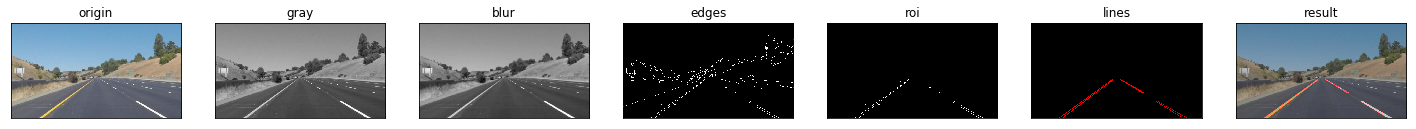

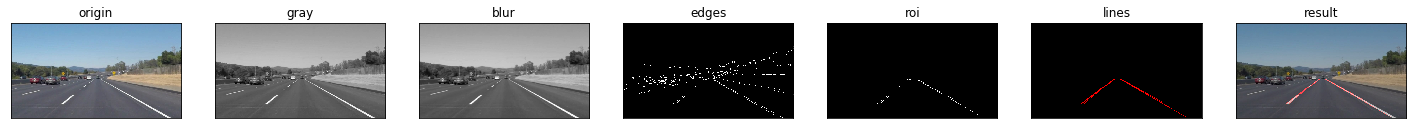

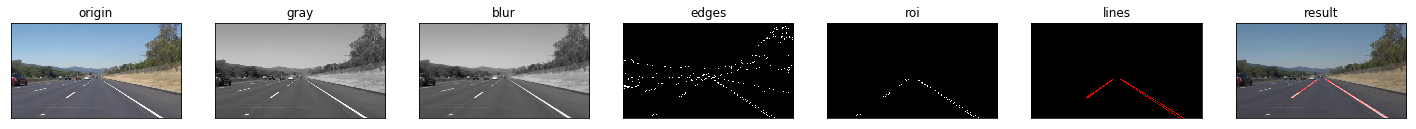

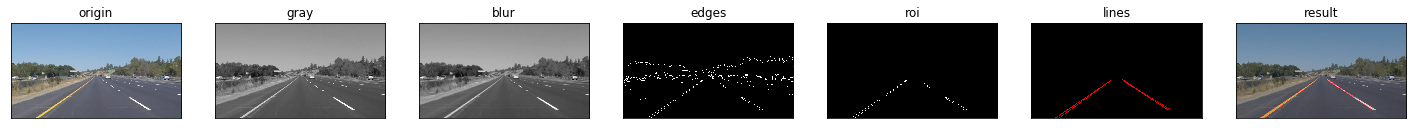

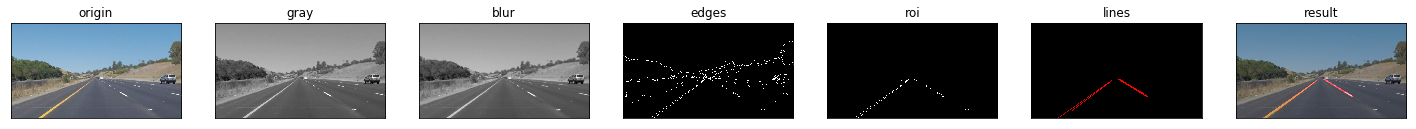

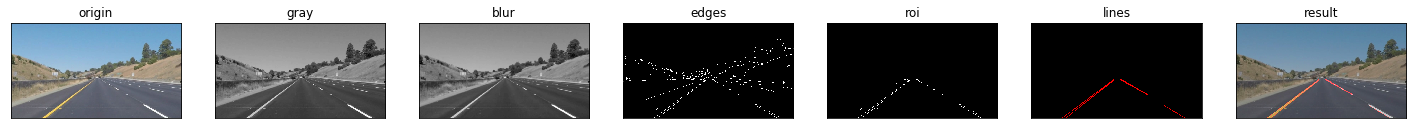

In [14]:
# Initial Test
display_lane_results("test_images/")

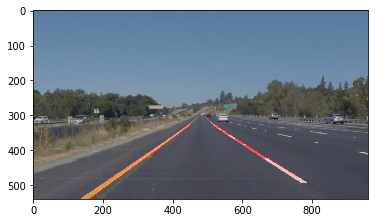

In [15]:
image = mpimg.imread("test_images/solidYellowLeft.jpg")
testresult = find_lane_lines(image)
plt.imshow(testresult)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = find_lane_lines(image)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [18]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:12<00:00, 15.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.61 s, sys: 218 ms, total: 2.83 s
Wall time: 14.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [153]:
def separate_lines(img, lines):
    """
    This functions separates the lane lines in an image
    """
    # find the middle of the lane
    middle = img.shape[1]/2
    left_lines = []
    right_lines = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            # if slope is distinctly negative and line is to the left of center
            if x1 < middle and slope < -0.5:
                left_lines.append(line)
            # else if slope is distinctly positive and line is to the right of center
            # elif because we want to filter out any lines outside of these criteria
            elif x2 > middle and slope > 0.5:
                right_lines.append(line)
        
    return left_lines, right_lines
    
def find_longest_line(left_lines, right_lines):
    """
    This function calculates the longest line for 2 sets of lines
    """
    
    longest_left_line = 0
    longest_right_line = 0
    
    my_left_lines = []
    my_right_lines = []
    
    for line in left_lines:
        for x1,y1,x2,y2 in line:
            distance = math.sqrt((abs(x2-x1))**2 + (abs(y2-y1))**2)
            if distance > longest_left_line:
                longest_left_line = distance
                my_left_lines.append(line)
                
    for line in left_lines:
        for x1,y1,x2,y2 in line:
            distance = math.sqrt((abs(x2-x1))**2 + abs(y2-y1)**2)
            if distance > longest_right_line:
                longest_right_line = distance
                my_right_lines.append(line)
                
    # last update is the longest line
    final_left = left_lines[-1] 
    final_right = right_lines[-1]
    
    return final_left, final_right

def extrapolate_lane(img, left_line, right_line):
        
    # To extrapolate lanes, we use knowns to calcalate unknowns
    # I want each line line to start at bottom of image : y1 = img.shape[0]
    # I want lane line to end at center of image -/+ 50 px respectively
    # Left Lane : x2 = img.shape[1]/2 - 50  , y2 = img.shape[0]/2 + 50
    # Right lane: x2 = img.shape[1]/2 + 50  , y2 = img.shape[0]/2 + 50
    # Given slope = (y2-y1)/(x2-x1)
    # x1 = (x2 - (y2-y1)) / slope
    
    # Thus:
    width = img.shape[1]
    height = img.shape[0]
    
    for x1,y1,x2,y2 in left_line:
        slope_left = (y2-y1)/(x2-x1)
        
    for x1,y1,x2,y2 in right_line:
        slope_right = (y2-y1)/(x2-x1)
    
    y1 = int(height)
    y2 = int(height/2 + 50)
    dy = abs(y2-y1)
 
    left_x2 = int(width/2 - 25)
    left_dx = int(dy / slope_left)
    left_x1 = left_x2 + left_dx
    
    right_x2 = int(width/2 + 25)
    right_dx = int(dy / slope_right)
    right_x1 = right_x2 + right_dx
    
    left_lane = [left_x1, y1, left_x2, y2]
    right_lane = [right_x1, y1, right_x2, y2]
    
    return left_lane, right_lane

def draw_lane(img, lane, color=[255, 0, 0], thickness=12):
    """
    This function draws `lanes` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    cv2.line(img, (lane[0], lane[1]), (lane[2], lane[3]), color, thickness)
    

def hough_lines_improved(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    left_lines, right_lines = separate_lines(img, lines)
    left_line, right_line = find_longest_line(left_lines, right_lines)
    left_lane, right_lane = extrapolate_lane(img, left_line, right_line)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lane(line_img, left_lane)
    draw_lane(line_img, right_lane)
    return line_img

In [154]:
def find_lane_lines_improved(image):
    """
    This function takes a color image and overlays lane lines on it
    """
    
    # Define parameters
    kernel_size = 5
    low_threshold = 50
    high_threshold = 150

    rho = 3
    theta = np.pi/180
    threshold = 50
    min_line_length = 100
    max_line_gap = 60
    
    # Process image
    gray = grayscale(image)

    # Apply Gaussian smoothing and apply Canny
    blur_gray = gaussian_blur(gray, kernel_size)
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Define region of interest
    # Defining vertices based on intuition of images
    width = image.shape[1]
    height = image.shape[0]
    # bottom of image minus noise past left lane marker
    bottom_left = (80,height)
    # center of lane FOV usually in center of image, we want top left mask to be to the left of it slightly
    top_left = (width/2-50, height/2+50)
    # bottom of image minus noise pass right lane marker
    bottom_right = (width-80,height)
    # center of lane FOV usually in center of image, we want top right mask to be to the right of it slightly
    top_right = (width/2+50, height/2+50)

    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)


    # Create Hough Lines
    line_image = hough_lines_improved(masked_image, rho, theta, threshold, min_line_length, max_line_gap)

    # Create weighted Image and store
    weighted_image = weighted_img(line_image, image, α=0.8, β=1., γ=0.)
    
    return weighted_image

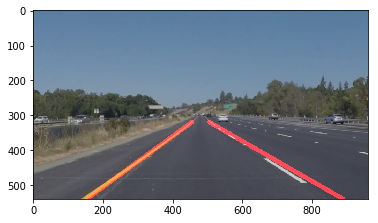

In [155]:
image = mpimg.imread("test_images/solidYellowLeft.jpg")
testresult = find_lane_lines_improved(image)
plt.imshow(testresult)

In [156]:
def process_image_improved(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = find_lane_lines_improved(image)
    
    return result

In [157]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_improved)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:45<00:00, 15.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 8.41 s, sys: 681 ms, total: 9.09 s
Wall time: 47 s


In [158]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


# Reflection

[//]: # (Image References)

[image1]: ./report_images/first_iteration.png "First Iteration"
[image2]: ./report_images/improved.png "Improved"

### 1. Describe your pipeline. As part of the description, explain how you modified the draw_lines() function.

My pipeline consisted of 5 steps. First I converted the images to grayscale. Then, I applied a guassian blur with a kernel size of (5,5). This allowed to me apply Canny edges to the scene. Once I had the Canny edges, I applied a mask based on a ROI for the lane lines. From here, I applied Hough Lines and overlayed it on the image. These first iteration of these can be shown in the image below:

![alt text][image1]

The draw_lines function had to be improved to extrapolate the lane lines across the whole line (instead of the dashes). To accomplish this I implemented separate_lines(), find_longest_line(), and extrapolate_line(). In order, these functions first separated the Hough Lines into left and right lines based on their position in the scene. Then I found the longest line for each region using distance between intercepts. I used these lines to extrapolate because I felt they represented their lane well, being the longest line. To extrapolate the line, I knew I wanted the bottom ends at the bottom of the image, and the top ends were defined based on the positions I chose for my original mask (about the center of the image). I just had to find the x intercepts for the bottom of the lanes and I did that by using the slope formula. The overall pipeline described above stayed the same and the improved result is shown below:

![alt text][image2]


### 2. Identify potential shortcomings with your current pipeline

In the video output, I can tell the lane lines are a little jittery. This is due to the fact that lane lines have thicknesses. The longest lane line that is extrapolated is sometimes at the left of the lane marker and sometimes at the right. This causes some differences in extrapolated across the video which leads to jitteriness. 

Another shortcoming is that the extrapolation of the lane lines relies heavily on the slope of the found hough lines. The test videos did not include any instances of sharp curves or turns. I think the code would struggle in this situations.

Another shortcoming is that my current pipeline cannot complete the challenge video.  I wanted to move along with the course at this time so I have saved this challenge for a future date.

### 3. Suggest possible improvements to your pipeline
To account for the jitter in the video, an improvement could be made to account for the previously extrapolated lane line. This takes me back to the lessons from the ITSDC ND where in localization, it is important to constantly take in data and also account for the previous path. I think this would improve the jumping around of lane lines as well.

To improve the extrapolation on curves, the lane lines could be fit to a nonlinear curve instead of a straight line. This would allow splines to match the curvature of the road.

For the challenge in the future, I would likely have to improve my masking to mask yellow colors and white colors separately in the image. Then I could pick up the yellow and white lane lines better in a mixed image that includes both.





## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [129]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



 40%|███▉      | 100/251 [00:10<00:21,  6.98it/s]

IndexError: list index out of range

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))